In [ ]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from itertools import combinations
import random
from sklearn.metrics import roc_auc_score, roc_curve
import editdistance
import numpy as np
import joblib
import matplotlib.pyplot as plt

In [64]:
def label_pair(row):
    same_word = row["text1"] == row["text2"]
    same_speaker = row["speaker1"] == row["speaker2"]
    if same_word and same_speaker:
        return "C1"
    elif same_word and not same_speaker:
        return "C2"
    elif not same_word and same_speaker:
        return "C3"
    else:
        return "C4"


def create_samediff_dataset(align_df: pd.DataFrame):
    segments = []
    seen_speakers = set()
    align_df = align_df[align_df["text"].notna()]
    align_df = align_df.sample(n=500, random_state=42)
    for filename in tqdm(align_df["filename"].unique(), desc="Processing files"):
        speaker = filename.split("-")[0]
        if speaker not in seen_speakers:
            seen_speakers.add(speaker)
        file_df = align_df[align_df["filename"] == filename]

        for word_id in file_df["word_id"].unique():
            word_df = file_df[file_df["word_id"] == word_id]
            if len(word_df) == 0:
                continue
            base_filename = filename.split("_")[0]
            text = str(word_df["text"].values[0])
            if not text or text == "<unk>" or text == "nan":
                continue
            segment = {
                "filename": base_filename,
                "speaker": speaker,
                "text": text,
                "word_start": word_df["word_start"].values[0],
                "word_end": word_df["word_end"].values[0],
                "phones": word_df["phones"].values[0],
            }
            segments.append(segment)
    segment_df = pd.DataFrame(segments)

    min_instances = 5
    word_counts = segment_df["text"].value_counts()
    valid_words = word_counts[word_counts >= min_instances].index
    subset_df = segment_df[segment_df["text"].isin(valid_words)].reset_index(drop=True)

    max_pairs_per_word = 1
    max_word_instances = 5
    same_pairs = []
    for _, group in tqdm(
        subset_df.groupby("text"), desc="Creating same pairs", total=len(valid_words)
    ):
        group = group[:max_word_instances]  # Keep first 100 occurrences only

        items = group.to_dict("records")
        all_combos = list(combinations(items, 2))
        sampled_combos = random.sample(
            all_combos, min(len(all_combos), max_pairs_per_word)
        )

        for a, b in sampled_combos:
            label = 1
            pair_type = label_pair(
                pd.Series(
                    {
                        "text1": a["text"],
                        "text2": b["text"],
                        "speaker1": a["speaker"],
                        "speaker2": b["speaker"],
                    }
                )
            )
            same_pairs.append((a, b, label, pair_type))

    all_items = subset_df.to_dict("records")
    diff_pairs = []
    attempts = 0
    max_attempts = len(same_pairs) * 10

    while len(diff_pairs) < len(same_pairs) and attempts < max_attempts:
        a, b = random.sample(all_items, 2)
        if a["text"] != b["text"]:
            label = 0
            pair_type = label_pair(
                pd.Series(
                    {
                        "text1": a["text"],
                        "text2": b["text"],
                        "speaker1": a["speaker"],
                        "speaker2": b["speaker"],
                    }
                )
            )
            diff_pairs.append((a, b, label, pair_type))
        attempts += 1

    pair_records = []
    for a, b, label, pair_type in same_pairs + diff_pairs:
        pair_records.append(
            {
                "file1": a["filename"],
                "speaker1": a["speaker"],
                "text1": a["text"],
                "start1": a["word_start"],
                "end1": a["word_end"],
                "phones1": a["phones"],
                "file2": b["filename"],
                "speaker2": b["speaker"],
                "text2": b["text"],
                "start2": b["word_start"],
                "end2": b["word_end"],
                "phones2": b["phones"],
                "label": label,
                "pair_type": pair_type,
            }
        )

    pairs_df = pd.DataFrame(pair_records)

    return pairs_df


In [65]:
align_df = pd.read_csv(Path("librispeech/alignments/dev-clean/alignments.csv"))
pairs_df = create_samediff_dataset(align_df)

Creating same pairs: 100%|██████████| 14/14 [00:00<00:00, 1914.27it/s]


In [66]:
print(pairs_df.to_string())
print(f"Number of pairs: {len(pairs_df)}")

               file1 speaker1 text1  start1   end1   phones1             file2 speaker2 text2  start2   end2   phones2  label pair_type
0    2428-83705-0026     2428     a    8.39   8.43       AH0    3752-4943-0000     3752     a    0.79   0.89       AH0      1        C2
1    3536-23268-0016     3536   and    2.72   2.87   AE1,N,D  1919-142785-0049     1919   and   12.14  12.31   AE1,N,D      1        C2
2   1988-147956-0013     1988    he    0.44   0.63    HH,IY1   251-137823-0022      251    he    0.32   0.52    HH,IY1      1        C2
3    3536-23268-0011     3536   her   10.04  10.16    HH,ER0  3170-137482-0017     3170   her    2.46   2.71    HH,ER0      1        C2
4   3853-163249-0030     3853   his    7.32   7.51  HH,IH1,Z   5895-34615-0019     5895   his    0.35   0.60  HH,IH1,Z      1        C2
5   2412-153948-0000     2412     i    2.24   2.35       AY1  8297-275155-0017     8297     i    1.04   1.18       AY1      1        C2
6    2428-83705-0037     2428    in    6.09   6.

In [79]:
def load_encodings(feat_dir: Path, align_df: pd.DataFrame, filenames_in_pairs_df: set):
    encodings = {}
    text = {}
    paths = list(feat_dir.glob("**/*.npy"))
    paths = [
        path
        for path in tqdm(paths, desc="Filtering files")
        if (
            path.stem.split("_")[0] in filenames_in_pairs_df
            and path.stem.split("_")[0] in align_df["filename"].values
        )
    ]

    for file in tqdm(paths, desc="Loading encodings"):
        filename = file.stem.split("_")[0]
        word_id = int(file.stem.split("_")[1])

        file_df = align_df[align_df["filename"] == filename]

        if word_id not in file_df["word_id"].values:
            print(f"⚠️ Word ID {word_id} not found in {filename}. Skipping.")
            continue

        word_df = file_df[file_df["word_id"] == word_id]
        start_time = word_df["word_start"].iloc[0]
        end_time = word_df["word_end"].iloc[0]

        key = (filename, float(start_time), float(end_time))
        encodings[key] = np.load(file)
        text[key] = str(word_df["text"].values[0])

    return encodings, text


def same_different_evaluation(
    pairs_df: pd.DataFrame, feat_dir: Path, align_df: pd.DataFrame
):
    filenames_in_pairs_df = set(pairs_df["file1"]).union(set(pairs_df["file2"]))
    word_encodings, text = load_encodings(feat_dir, align_df, filenames_in_pairs_df)

    skipped = 0
    labels = []
    scores = []

    for _, row in pairs_df.iterrows():
        key1 = (row["file1"], row["start1"], row["end1"])
        key2 = (row["file2"], row["start2"], row["end2"])
        seq1 = word_encodings.get(key1)
        seq2 = word_encodings.get(key2)

        if seq1 is None or len(seq1) == 0:
            skipped += 1
            continue
        if seq2 is None or len(seq2) == 0:
            skipped += 1
            continue

        d = editdistance.eval(seq1, seq2) / max(len(seq1), len(seq2))
        score = -d
        print(
            f"{text.get(key1)} [{seq1}] vs {text.get(key2)} [{seq2}]: {score:.3f} (label: {row['label']})"
        )

        labels.append(row["label"])
        scores.append(score)

    print(f"Skipped {skipped} pairs due to missing encodings.")

    if len(set(labels)) < 2:
        print("⚠️ Not enough positive/negative samples to compute ROC.")
        return

    auc = roc_auc_score(labels, scores)
    fpr, tpr, _ = roc_curve(labels, scores)

    # Plot once
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Same-Different ROC Curve")
    plt.grid()
    plt.legend()
    plt.tight_layout()


Loading encodings: 100%|██████████| 1632/1632 [00:05<00:00, 272.83it/s]


a [[ 9 47]] vs a [[ 9 27 47 30 39]]: -0.600 (label: 1)
and [[44 19 34 38]] vs and [[44 19 34 43  3]]: -0.400 (label: 1)
he [[ 8  1 44 11 17 14]] vs he [[ 1 44 46 14 33]]: -0.667 (label: 1)
her [[43  2 28 26 30]] vs her [[43 28 26 48 12]]: -0.600 (label: 1)
his [[31 27 30 33 37 11]] vs his [[24  1 44 27 30 33 37 11]]: -0.375 (label: 1)
i [[44 19  0]] vs i [[12 35]]: -1.000 (label: 1)
in [[27 34 38]] vs in [[46 27 34 38]]: -0.250 (label: 1)
is [[46 27 29 33 37 11 21  8]] vs is [[27 30 33 37]]: -0.625 (label: 1)
it [[29 39 21]] vs it [[ 8  1 27 30 43]]: -1.000 (label: 1)
of [[43 47 33]] vs of [[27 47  3 41 27]]: -0.800 (label: 1)
the [[42 47]] vs the [[38 42 47]]: -0.333 (label: 1)
to [[39  2 47]] vs to [[ 6  2 27 30]]: -0.750 (label: 1)
was [[32 23 47 33 11]] vs was [[31 32 17 47 30 33 37]]: -0.571 (label: 1)
were [[32 28 48 33]] vs were [[31 32 28 48]]: -0.500 (label: 1)
in [[27 34 38]] vs he [[11 27 46 14]]: -0.750 (label: 0)
were [[ 3 32 28 26 48 30]] vs his [[43 27 30 33]]: -1.000 (l

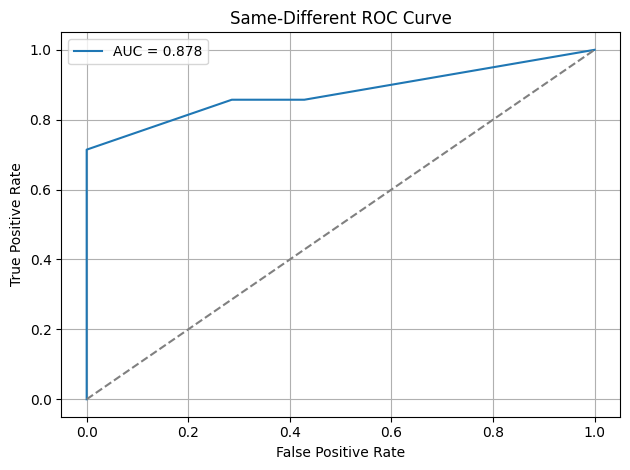

In [83]:
same_different_evaluation(
    pairs_df,
    Path("features/wavlm_large/layer11/gamma0.1/k50"),
    align_df,
)

In [ ]:
from encode_features import cut_encoding, segment

align_dir = Path("librispeech/alignments/dev-clean")
audio_dir = Path("librispeech/dev-clean")
model_name = "wavlm_large"
layer = 11
n_clusters = 50

align_df = pd.read_csv(align_dir / "alignments.csv")
raw_features_dir = Path("raw_features") / audio_dir / model_name / f"layer{layer}"

raw_paths = list(raw_features_dir.rglob("**/*.npy"))
print(f"Raw features dir: {raw_features_dir} has {len(raw_paths)} files")

raw_paths = random.sample(raw_paths, 2)
kmeans_path = f"kmeans_models/kmeans_{model_name}_layer{layer}_k{n_clusters}.pkl"
kmeans = joblib.load(kmeans_path)

Raw features dir: raw_features/librispeech/dev-clean/wavlm_large/layer11 has 2703 files


In [40]:
gamma = 0.9

for path in tqdm(
    raw_paths,
    total=len(raw_paths),
    desc="Encoding features",
):
    wav_df = align_df[align_df["filename"] == path.stem]
    encoding = np.load(path)
    for w in range(1, max(wav_df["word_id"]) + 1):
        word_df = wav_df[wav_df["word_id"] == w]
        if str(word_df["text"].iloc[0]) == "nan":
            continue
        word_encoding = cut_encoding(
            encoding,
            [word_df["word_start"].iloc[0], word_df["word_end"].iloc[0]],
        )
        codes = []
        if len(word_encoding) > 0:
            codes = segment(word_encoding, kmeans.cluster_centers_, gamma)
            print(f"word {word_df['text'].iloc[0]}: {codes}")

Encoding features: 100%|██████████| 2/2 [00:00<00:00, 83.82it/s]

word they: [8, 42, 19, 5]
word began: [14, 16, 18, 20, 17, 14, 18, 20, 2, 17, 19, 35, 34, 38]
word their: [38, 42, 27, 26, 48]
word performances: [18, 20, 22, 28, 48, 41, 22, 32, 10, 48, 15, 9, 27, 34, 38, 39, 37, 27, 29, 33, 37, 11, 21]
word no: [8, 1, 38, 15, 9, 19, 23, 10, 3, 21]
word it's: [25, 1, 8, 44, 27, 30, 39, 11, 28]
word only: [23, 10, 34, 38, 9, 27, 14]
word painful: [18, 20, 22, 19, 5, 38, 39, 41, 22, 10]
word for: [41, 22, 28, 48]
word both: [16, 18, 20, 9, 23, 3, 39, 45]
word of: [42, 47, 41, 9]
word us: [23, 0, 33, 37, 11, 21]
